In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils
from wiki.newphet import load_prophet_prop
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output

# Should look for where it beats median all the time?

In [3]:
PROPHET_PATH = '../data/prophet/'
RESULTS_PATH = 'results/'
VERSION ='v7t/'

In [4]:
mediandf = pd.read_feather('../data/median_for_120_60.f') 

In [9]:
mediandf.page_index = mediandf.page_index.astype(int)
mediandf = mediandf.sort_values(by='page_index').reset_index().drop('index', axis=1)
print(mediandf.iloc[:,2:].mean())
print(mediandf.info())
mediandf.head()

median_pred_60               945.877619
median_pred_120             1079.880355
prevYear_median_pred_60     1088.881776
prevYear_median_pred_120    1088.969089
smape_60_to_0                 41.043204
smape_120_to_60               40.059153
prevYear_smape_60_to_0        50.551424
prevYear_smape_120_to_60      47.544453
nans_start_to_120             45.414792
nans_120_to_60                 1.424264
nans_60_to_0                   1.536367
prevYear_nans_60_to_0          2.868712
prevYear_nans_120_to_60        3.540000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 15 columns):
page_index                  145063 non-null int64
Page                        145063 non-null object
median_pred_60              145063 non-null int64
median_pred_120             145063 non-null int64
prevYear_median_pred_60     145063 non-null int64
prevYear_median_pred_120    145063 non-null int64
smape_60_to_0               144151 non-null float64
s

,page_index,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,smape_60_to_0,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60
0,0,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,32.278432,25.959053,40.870388,32.116348,0,0,0,0,0
1,1,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,42.847863,34.415304,60.431899,32.054860,0,0,0,0,0
2,2,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,64.305367,65.870407,47.163640,56.748585,0,0,0,0,0
3,3,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,32.250349,33.896551,35.401843,49.278494,0,0,0,0,0
4,4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,48.547274,38.718059,54.426324,57.220372,291,0,0,0,0


In [18]:
test_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+VERSION[:-1]+'df.f'); 
test_df.page_index = test_df.page_index.astype(int)
print(test_df[VERSION[:-1]+'_train'].mean())
test_df = test_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
test_df = test_df.drop(VERSION[:-1]+'_train', axis=1)
print(test_df.shape)
print(test_df.info())
print(test_df[VERSION[:-1]+'_val'].mean())
test_df.head()

66.9608163262
(145063, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 2 columns):
page_index    145063 non-null int64
v7t_val       144151 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.2 MB
None
99.0350088156


,page_index,v7t_val
0,0,32.642601
1,1,83.565553
2,2,120.451293
3,3,38.493515
4,4,89.498846


In [19]:
df = mediandf.merge(test_df, on='page_index'); print(df.shape)
df['test_gain'] = df.smape_60_to_0 - df[VERSION[:-1]+'_val']; df.head()

(145063, 16)


,page_index,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,smape_60_to_0,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60,v7t_val,test_gain
0,0,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,32.278432,25.959053,40.870388,32.116348,0,0,0,0,0,32.642601,-0.364169
1,1,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,42.847863,34.415304,60.431899,32.054860,0,0,0,0,0,83.565553,-40.717689
2,2,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,64.305367,65.870407,47.163640,56.748585,0,0,0,0,0,120.451293,-56.145926
3,3,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,32.250349,33.896551,35.401843,49.278494,0,0,0,0,0,38.493515,-6.243166
4,4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,48.547274,38.718059,54.426324,57.220372,291,0,0,0,0,89.498846,-40.951572


In [20]:
train = pd.read_feather('../data/train.f'); train.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [21]:
yhat = load_prophet_prop('v7t/', 'yhat'); yhat.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,20.0,16.0,18.0,17.0,16.0,13.0,15.0,14.0,11.0,13.0,...,23.0,23.0,20.0,23.0,23.0,23.0,21.0,24.0,24.0,21.0
1,24.0,24.0,28.0,34.0,28.0,28.0,35.0,31.0,29.0,32.0,...,61.0,57.0,54.0,56.0,60.0,53.0,51.0,57.0,52.0,49.0
2,4.0,1.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,0.0,...,0.0,2.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,1.0
3,26.0,24.0,25.0,25.0,22.0,25.0,23.0,23.0,21.0,22.0,...,12.0,12.0,10.0,11.0,12.0,9.0,12.0,10.0,10.0,8.0
4,4.0,5.0,3.0,5.0,6.0,2.0,0.0,2.0,3.0,1.0,...,0.0,4.0,5.0,4.0,7.0,8.0,6.0,3.0,8.0,10.0


In [24]:
train.shape == yhat.shape

True

In [63]:
def get_smape_df(train, yhat):
    denominator = (train + yhat) / 200
    diff = np.abs(train - yhat) / denominator
    diff[denominator == 0] = 0.0
    #return np.nanmean(diff, axis=0)
    #diff.mean(axis=1, skipna=True)
    return diff

In [41]:
get_smape_df(train.iloc[:,:-60],yhat.iloc[:,:-60]).mean(axis=1).mean() #66.960816326237776

66.960816326237776

In [54]:
get_smape_df(train.iloc[:,:-60],yhat.iloc[:,:-60]).mean(axis=1).head()

0    46.736751
1    48.666767
2    69.758611
3    45.255355
4    66.002965
dtype: float64

# NOTE: the axis which means taken over matters (is it because of nans?)
* it's because you're a fucking idiot

In [42]:
get_smape_df(train.iloc[:,:-60],yhat.iloc[:,:-60]).mean().mean()

65.54489110121537

In [59]:
get_smape_df(train.iloc[:,:-60],yhat.iloc[:,:-60]).mean().head()

2015-07-01    86.464342
2015-07-02    84.267145
2015-07-03    82.947009
2015-07-04    83.732917
2015-07-05    80.403061
dtype: float64

In [64]:
yhat_smape = get_smape_df(train,yhat)

In [81]:
yhat_smape.iloc[:,-60:].mean(axis=1).mean() #99.03500881

99.035008815627705

In [87]:
yhat_smape.iloc[:,-60:].mean(axis=0).mean()

98.416331271317958

In [85]:
yhat_smape.iloc[:,-60:].shape

(145063, 60)

# WARNING: must have `min_periods=0` or will through nans

In [91]:
yhat_smape.rolling(60, axis=1, min_periods=0).mean().mean(axis=0)[-1] # should be 99.03500881

99.035008815628132

In [92]:
yhat_smape.rolling(60, axis=1).mean().mean(axis=0)[-1] # should be 99.03500881

96.568814431578616

In [96]:
yhat_smape.iloc[0,0]

10.526315789473685

In [95]:
yhat_smape.rolling(60, axis=1, min_periods=0).mean().iloc[0,0]

10.526315789473685

# Slice the first 60 off as these don't include full 60 vals

In [97]:
yhat_rolling_smape = yhat_smape.rolling(60, axis=1, min_periods=0).mean().iloc[60:]

# Got yhat rolling smape

# TESTING

In [98]:
dft = pd.DataFrame({'B': [0, 1, 2, np.nan, 4]},
                   index=pd.date_range('20130101 09:00:00', periods=5, freq='s'))

In [99]:
dft.rolling(2).sum()

,B
2013-01-01 09:00:00,NaN
2013-01-01 09:00:01,1.0
2013-01-01 09:00:02,3.0
2013-01-01 09:00:03,NaN
2013-01-01 09:00:04,NaN


# Get Median Rolling Smape

In [ ]:
def med_preds_period(train, period):
    return np.nan_to_num(np.round(
                        np.nanmedian(
                        train.drop('Page', axis=1).iloc[:,:period[1]].values[:, -49:], axis=1)).reshape(-1,1)).astype(int)

In [ ]:
def get_med_pred_from_49_window

In [19]:
def median_smape_period(train, preds, period):
    denominator = train.iloc[:,period[0]:period[1]].add(preds, axis=0) / 200
    diff = np.abs(train.iloc[:,period[0]:period[1]].subtract(preds, axis=0)) / denominator
    diff[denominator == 0] = 0.0
    #return np.nanmean(diff, axis=0)
    return diff.mean(axis=1, skipna=True)

In [28]:
df.prevYear_smape_60_to_0.mean()

50.551424330915339

In [29]:
(df[df['val_gain']>0].v7ty_val.sum() + df[~(df['val_gain']>0)].prevYear_smape_60_to_0.sum())/len(df)

44.088290194370238

In [37]:
BASE_SMAPE = df.smape_60_to_0.mean(); BASE_SMAPE

41.043204039840212

In [31]:
(df[df['val_gain']>0].v7t_val.sum() + df[~(df['val_gain']>0)].smape_60_to_0.sum())/len(df)

52.736377651095907

In [36]:
(df[df['test_gain']>0].v7t_val.sum() + df[~(df['test_gain']>0)].smape_60_to_0.sum())/df)

39.34201873420573

In [33]:
df[df['val_gain']>0].shape

(35944, 19)

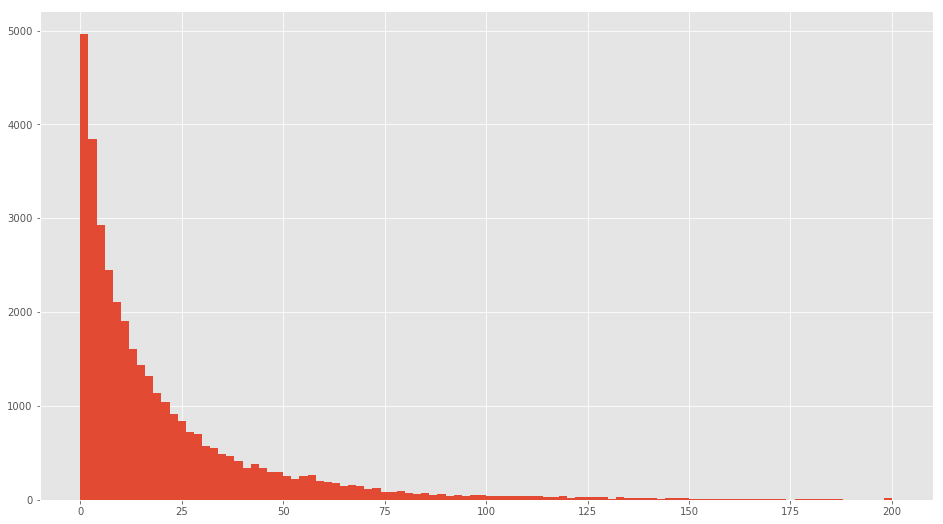

In [19]:
df[df['val_gain']>0].val_gain.hist(bins=100)

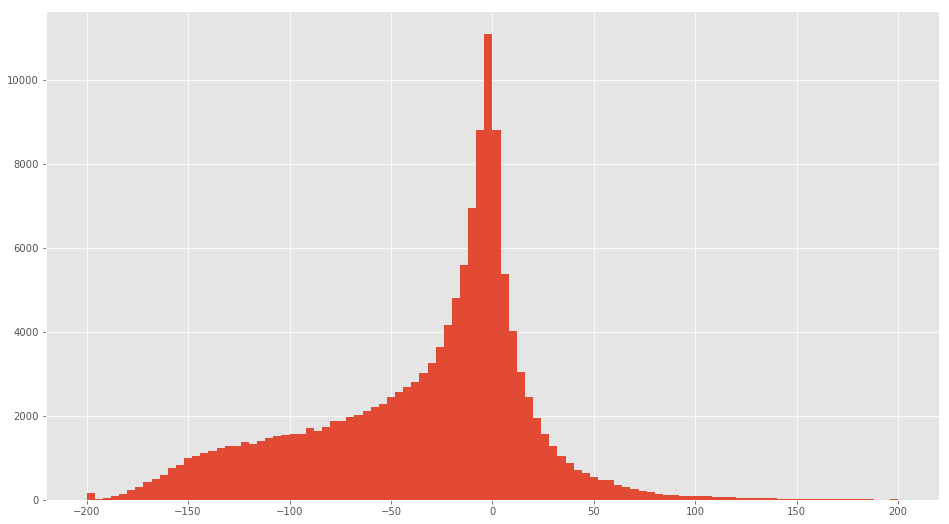

In [32]:
df.val_gain.hist(bins=100)

In [35]:
df[['val_gain','test_gain']].corr()

,val_gain,test_gain
val_gain,1.000000,0.288918
test_gain,0.288918,1.000000


In [38]:
df.columns

Index(['page_index', 'v7ty_val', 'v7t_val', 'Page', 'median_pred_60',
       'median_pred_120', 'prevYear_median_pred_60',
       'prevYear_median_pred_120', 'smape_60_to_0', 'smape_120_to_60',
       'prevYear_smape_60_to_0', 'prevYear_smape_120_to_60',
       'nans_start_to_120', 'nans_120_to_60', 'nans_60_to_0',
       'prevYear_nans_60_to_0', 'prevYear_nans_120_to_60', 'val_gain',
       'test_gain'],
      dtype='object')

In [53]:
from scipy.optimize import brute

In [60]:
def get_df_for_thresh(threshs):
    upper_threshold = threshs[0]
    lower_threshold  = threshs[1]
    nan_threhshold = threshs[2]
    filter_df = ((df.val_gain < upper_threshold) &
                 (df.val_gain > lower_threshold) &
                 (df.prevYear_nans_60_to_0 <= nan_threhshold))
    return df[filter_df]

In [39]:
def test_smape_for_thresholds(threshs):
    upper_threshold = threshs[0]
    lower_threshold  = threshs[1]
    nan_threhshold = threshs[2]
    filter_df = ((df.val_gain <= upper_threshold)
                 & (df.val_gain >= lower_threshold)
                 & (df.nans_start_to_120 <= nan_threhshold))
    proph_test_sum = df[filter_df].v7t_val.sum()
    proph_test_count = df[filter_df].v7t_val.count()
    smape_60_0_sum = df[~filter_df].smape_60_to_0.sum()
    smape_60_0_count = df[~filter_df].smape_60_to_0.count()
    return ((proph_test_sum + smape_60_0_sum) / (proph_test_count + smape_60_0_count))

In [52]:
test_smape_for_thresholds((201,0,30)) 

52.602892670341554

In [104]:
c = brute(test_smape_for_thresholds,[(0,200),(0,200),(0,790)],full_output = True)

In [105]:
BASE_SMAPE

41.043204039840212

In [106]:
c

(array([ 210.        ,  189.47368421,   83.15789474]),
 41.041980575494968,
 array([[[[   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ],
          [   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ],
          [   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ],
          ..., 
          [   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ],
          [   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ],
          [   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ]],
 
         [[  10.52631579,   10.52631579,   10.52631579, ...,   10.52631579,
             10.52631579,   10.52631579],
          [  10.52631579,   10.52631579,   10.52631579, ...,   10.52631579,
   

In [73]:
c[0]

array([ 101.,  105.,   30.])

In [74]:
BASE_SMAPE - c[1]

0.0

In [75]:
print(get_df_for_thresh(c[0]).shape)
get_df_for_thresh(c[0])

(0, 19)


,page_index,v7ty_val,v7t_val,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,smape_60_to_0,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60,val_gain,test_gain


In [77]:
filter_df = ((df.val_gain > 0 ) & (df.test_gain > 0))
df[filter_df]

,page_index,v7ty_val,v7t_val,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,smape_60_to_0,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60,val_gain,test_gain
178,178,38.600828,43.663474,VIXX_zh.wikipedia.org_all-access_spider,37,23,26,30,47.235848,62.900209,38.970386,45.628213,0,0,0,0,0,0.369557,3.572374
245,245,35.272283,39.663524,夜魔俠_(電視劇)_zh.wikipedia.org_all-access_spider,15,21,13,13,43.498867,37.380960,45.607938,37.108955,0,0,0,0,0,10.335655,3.835343
252,252,28.687509,28.889281,维生素C_zh.wikipedia.org_all-access_spider,24,19,18,16,33.483282,28.186674,30.241808,30.791867,0,0,0,0,0,1.554299,4.594002
257,257,45.678226,37.869894,跳水_zh.wikipedia.org_all-access_spider,11,13,7,8,39.721670,33.661312,52.087896,38.206119,0,0,0,0,0,6.409671,1.851776
373,373,45.651942,64.463945,麗茲·凱普蘭_zh.wikipedia.org_all-access_spider,5,4,6,4,64.869626,49.486854,45.701172,46.331807,0,0,0,0,0,0.049230,0.405682
414,414,30.455397,27.297888,吳清源_zh.wikipedia.org_all-access_spider,15,13,9,14,30.420181,28.087818,35.777016,58.198856,0,0,0,0,0,5.321619,3.122293
478,478,53.724306,38.951855,阿爾宙斯_zh.wikipedia.org_all-access_spider,6,6,5,6,46.553911,46.739689,55.746654,42.913498,0,0,0,0,0,2.022348,7.602056
549,549,36.143500,37.638390,成龍_zh.wikipedia.org_all-access_spider,26,31,21,20,41.594981,29.462710,38.284131,25.170139,0,0,0,0,0,2.140631,3.956591
552,552,54.480371,61.434684,婦女節、兒童節合併假期_zh.wikipedia.org_all-access_spider,3,10,6,8,63.075896,89.385159,55.164157,42.642319,0,0,0,0,0,0.683785,1.641212
559,559,35.130871,45.092685,斯里尼瓦瑟·拉马努金_zh.wikipedia.org_all-access_spider,19,13,14,9,49.721287,45.694531,36.324485,48.574933,0,0,0,0,0,1.193614,4.628602


In [85]:
def load_plot(page, plot_y_org=True):
    forecast = pd.read_feather(PROPHET_PATH+VERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()
    forecast = pd.read_feather(PROPHET_PATH+TVERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()

In [103]:
for row in df[(df['val_gain'] > 0) & (df['val_gain'] < 190)].sort_values(
    by='val_gain', ascending=False).iloc[:0].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

In [102]:
for row in df[(df['val_gain'] > 0) & (df['val_gain'] < 190) & (df['nans_start_to_120'] < 100)].sort_values(
    by='val_gain', ascending=False).iloc[:0].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

In [101]:
for row in df[(df['val_gain'] > 0) &
              (df['val_gain'] < 100) &
              (df['nans_start_to_120'] < 100) &
              (df['test_gain'] > 0)].sort_values(
    by='val_gain', ascending=False).iloc[:0].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

In [100]:
for row in df[(df['val_gain'] > 0) &
              (df['val_gain'] < 100) &
              (df['nans_start_to_120'] < 100) &
              (df['test_gain'] > 0)].sort_values(
    by='test_gain', ascending=False).iloc[:0].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

In [99]:
for row in df[(df['val_gain'] > 0) &
              (df['val_gain'] < 50) &
              (df['nans_start_to_120'] < 100) &
              (df['test_gain'] > 0) &
              (df['test_gain'] < 50)].sort_values(
    by='test_gain', ascending=False).iloc[:0].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

page_index                                                           108169
v7ty_val                                                            63.7267
v7t_val                                                             36.8991
Page                        NBA總冠軍列表_zh.wikipedia.org_mobile-web_all-agents
median_pred_60                                                          570
median_pred_120                                                         181
prevYear_median_pred_60                                                 375
prevYear_median_pred_120                                                170
smape_60_to_0                                                       136.624
smape_120_to_60                                                     82.2768
prevYear_smape_60_to_0                                               111.12
prevYear_smape_120_to_60                                            66.6134
nans_start_to_120                                                         0
nans_120_to_

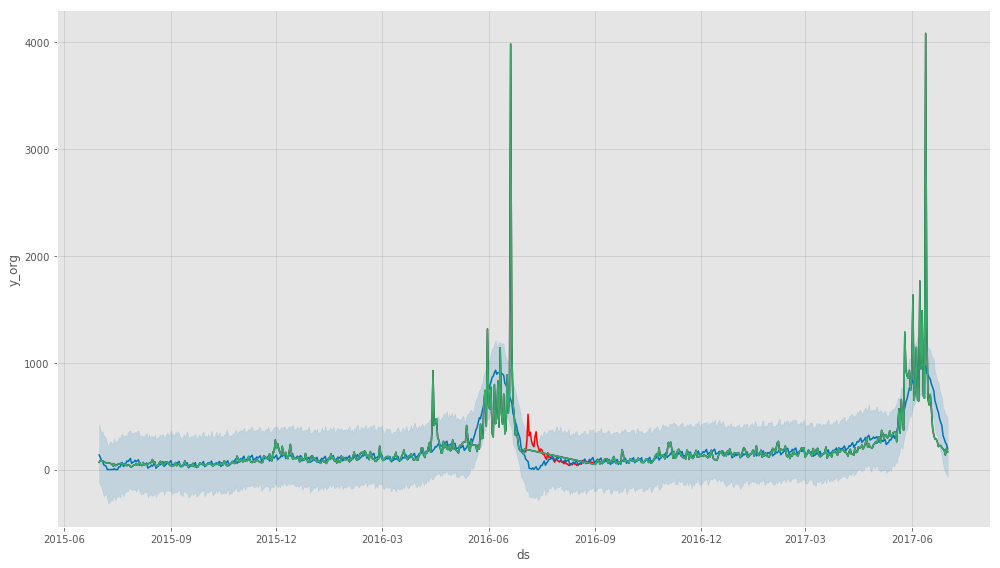

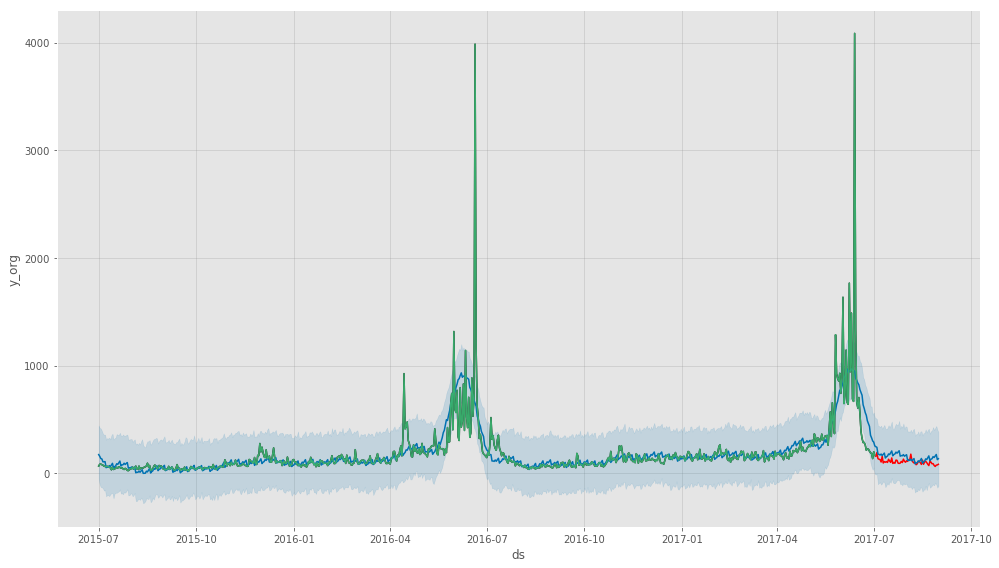

page_index                                                            30989
v7ty_val                                                            61.2117
v7t_val                                                             33.9528
Page                        NBA總冠軍列表_zh.wikipedia.org_all-access_all-agents
median_pred_60                                                         1037
median_pred_120                                                         352
prevYear_median_pred_60                                                 815
prevYear_median_pred_120                                                358
smape_60_to_0                                                       128.776
smape_120_to_60                                                     84.4222
prevYear_smape_60_to_0                                              107.084
prevYear_smape_120_to_60                                             70.585
nans_start_to_120                                                         0
nans_120_to_

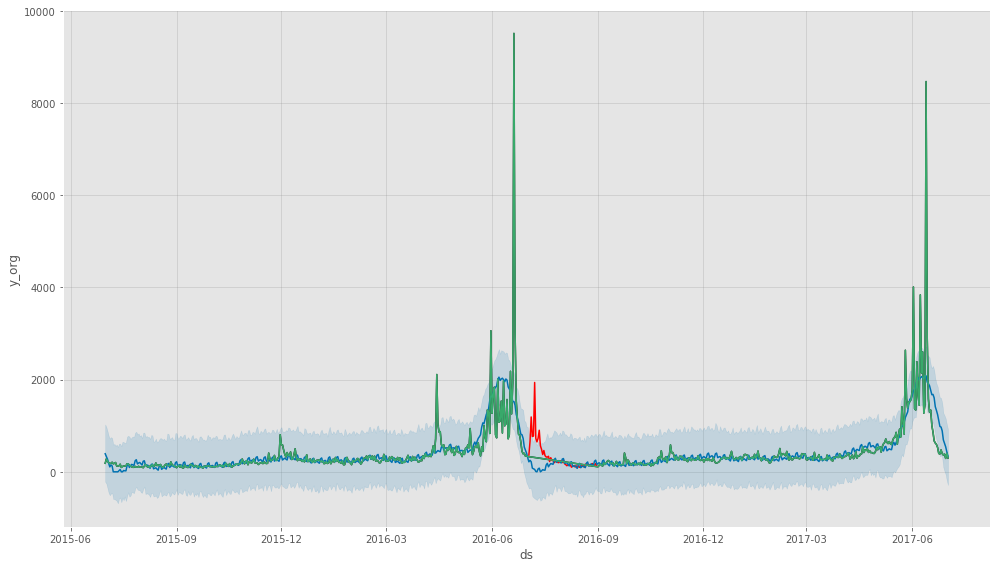

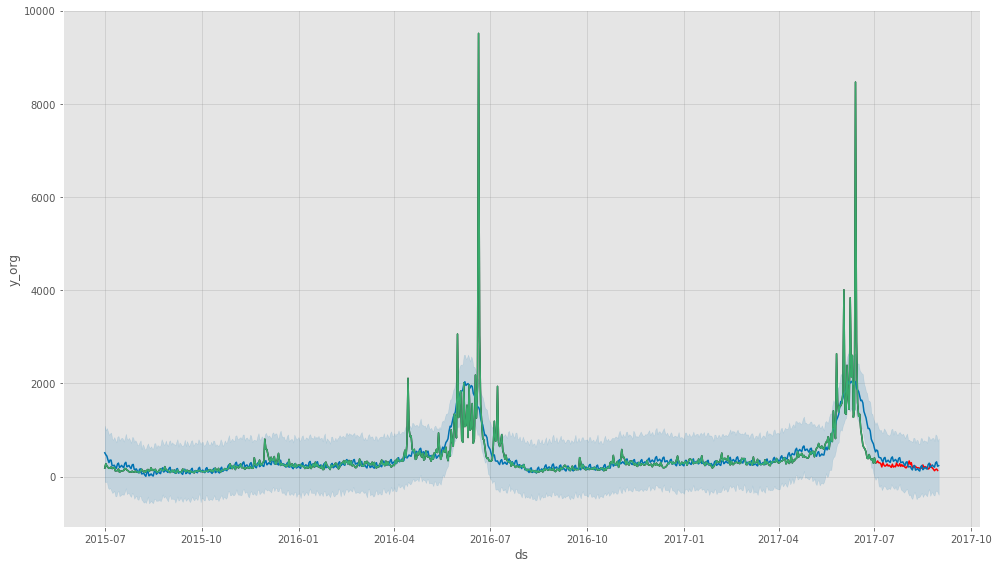

page_index                                                              78882
v7ty_val                                                              145.597
v7t_val                                                               70.3704
Page                        File:WLE_Austria_Logo_(transparent).svg_common...
median_pred_60                                                              4
median_pred_120                                                             0
prevYear_median_pred_60                                                    14
prevYear_median_pred_120                                                    0
smape_60_to_0                                                         161.552
smape_120_to_60                                                       183.333
prevYear_smape_60_to_0                                                181.929
prevYear_smape_120_to_60                                              193.333
nans_start_to_120                                               

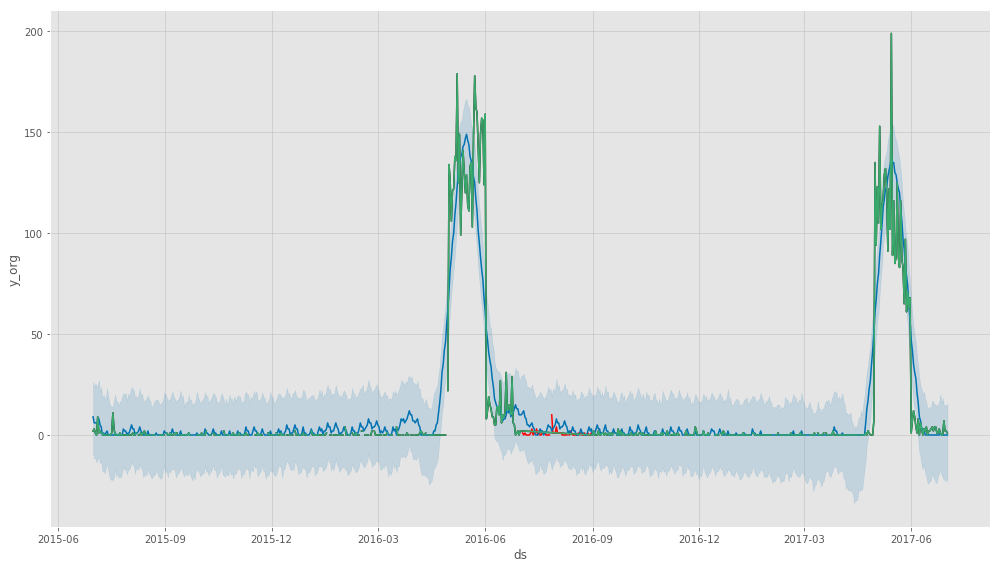

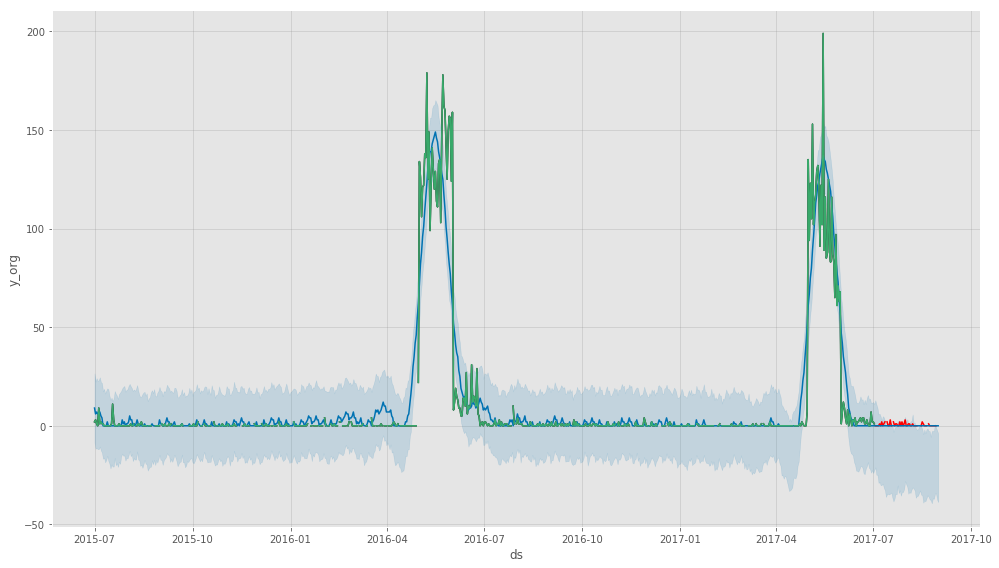

page_index                                                              96218
v7ty_val                                                              39.0802
v7t_val                                                               29.9904
Page                        Pentecostés_es.wikipedia.org_mobile-web_all-ag...
median_pred_60                                                           1584
median_pred_120                                                           751
prevYear_median_pred_60                                                   779
prevYear_median_pred_120                                                  960
smape_60_to_0                                                         120.246
smape_120_to_60                                                       65.3623
prevYear_smape_60_to_0                                                75.5917
prevYear_smape_120_to_60                                              62.7126
nans_start_to_120                                               

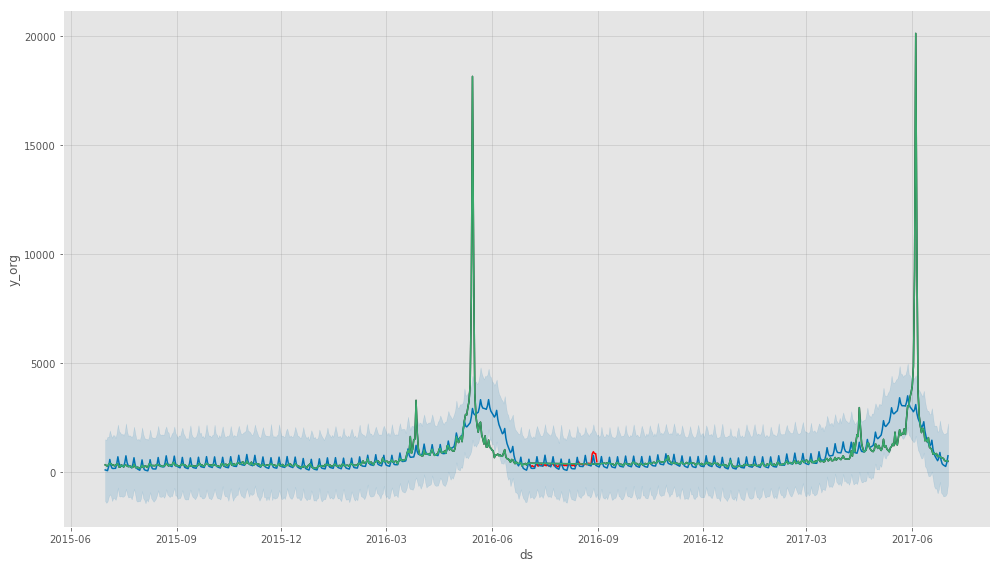

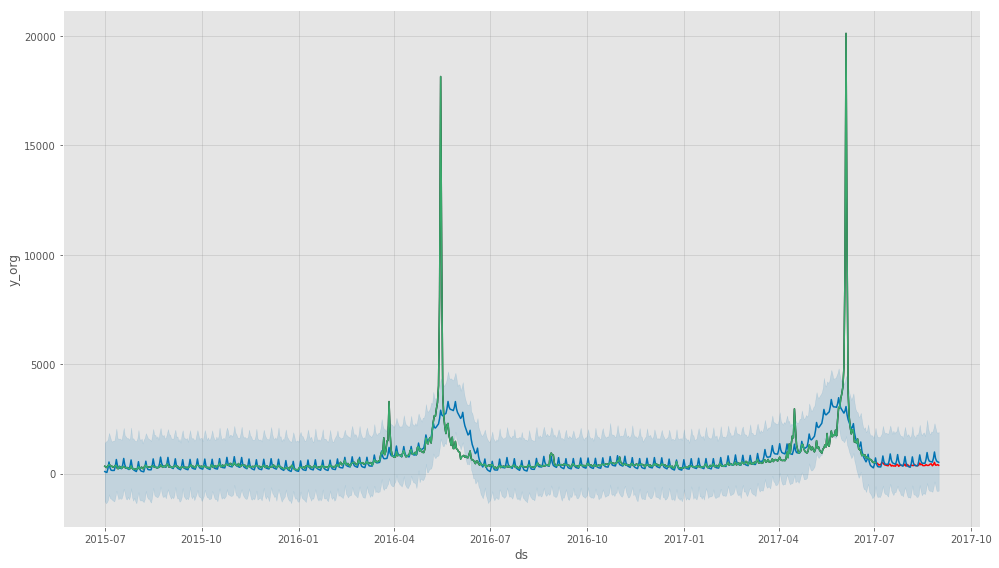

page_index                                                       106053
v7ty_val                                                        67.4197
v7t_val                                                         38.8576
Page                        性在有情_zh.wikipedia.org_mobile-web_all-agents
median_pred_60                                                      296
median_pred_120                                                      54
prevYear_median_pred_60                                             565
prevYear_median_pred_120                                             66
smape_60_to_0                                                   128.716
smape_120_to_60                                                 99.3707
prevYear_smape_60_to_0                                          94.9306
prevYear_smape_120_to_60                                        104.528
nans_start_to_120                                                     0
nans_120_to_60                                                  

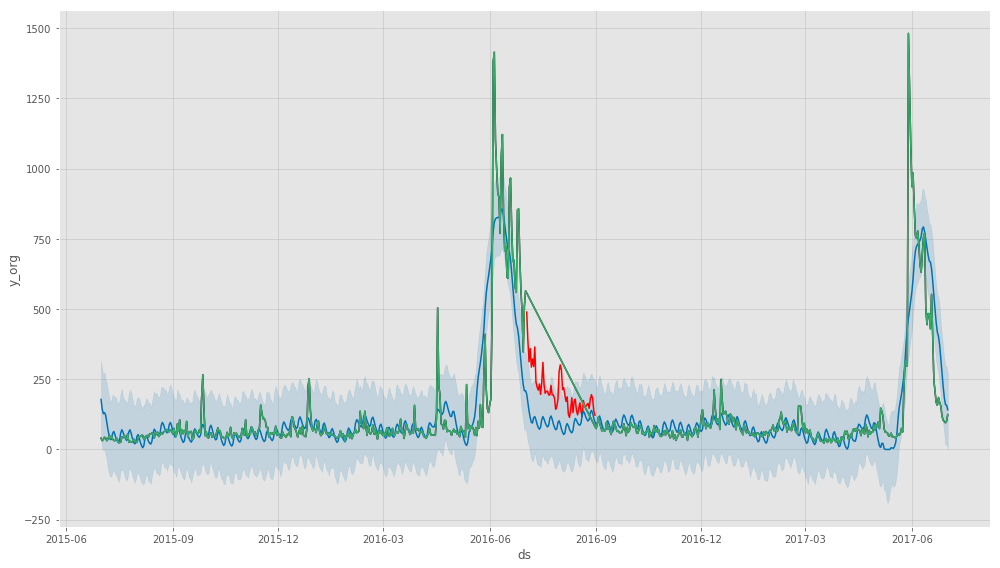

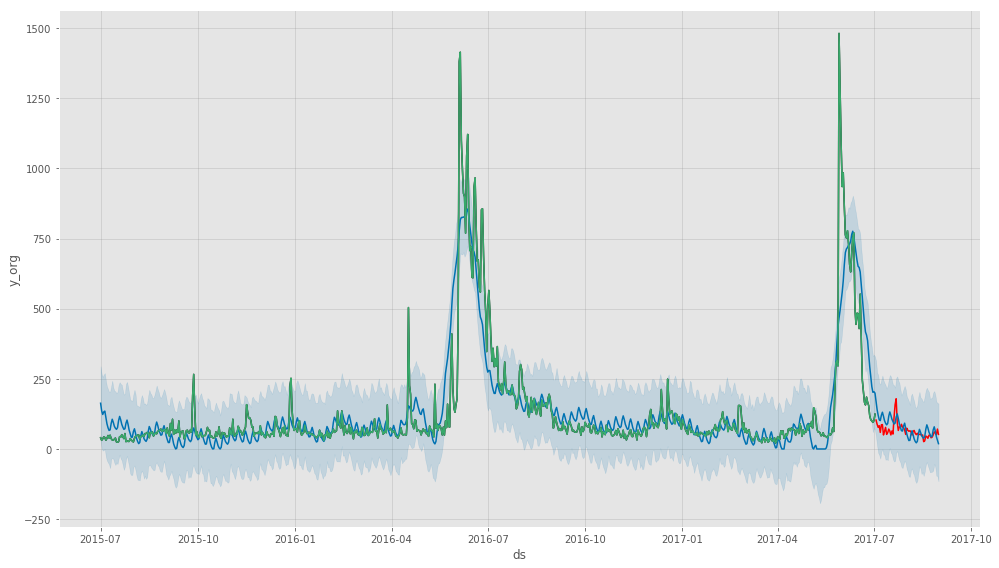

page_index                                                              27238
v7ty_val                                                              40.2789
v7t_val                                                               24.5697
Page                        Power_(série_télévisée)_fr.wikipedia.org_all-a...
median_pred_60                                                            389
median_pred_120                                                           347
prevYear_median_pred_60                                                   417
prevYear_median_pred_120                                                  367
smape_60_to_0                                                         112.792
smape_120_to_60                                                       26.5449
prevYear_smape_60_to_0                                                71.2185
prevYear_smape_120_to_60                                              16.0658
nans_start_to_120                                               

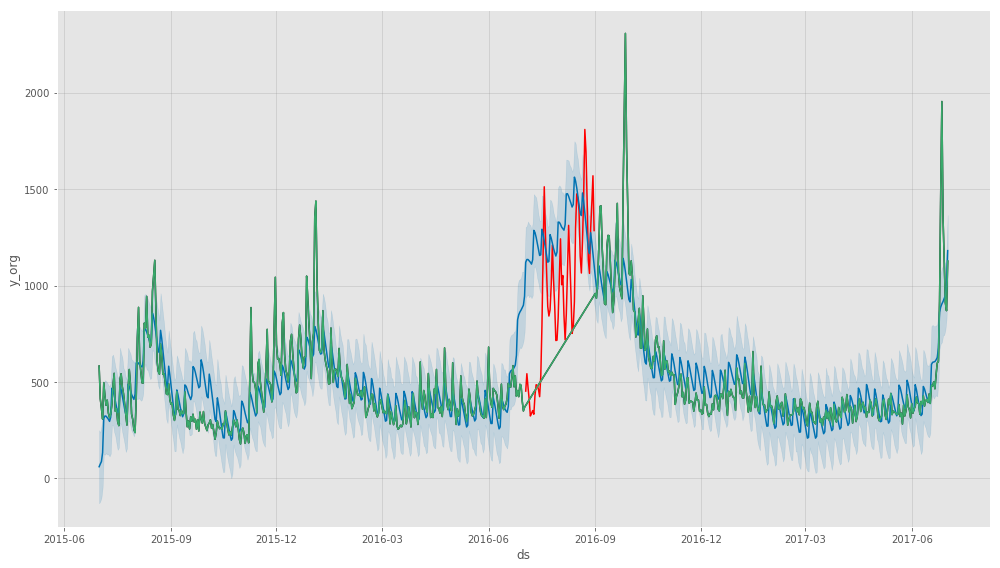

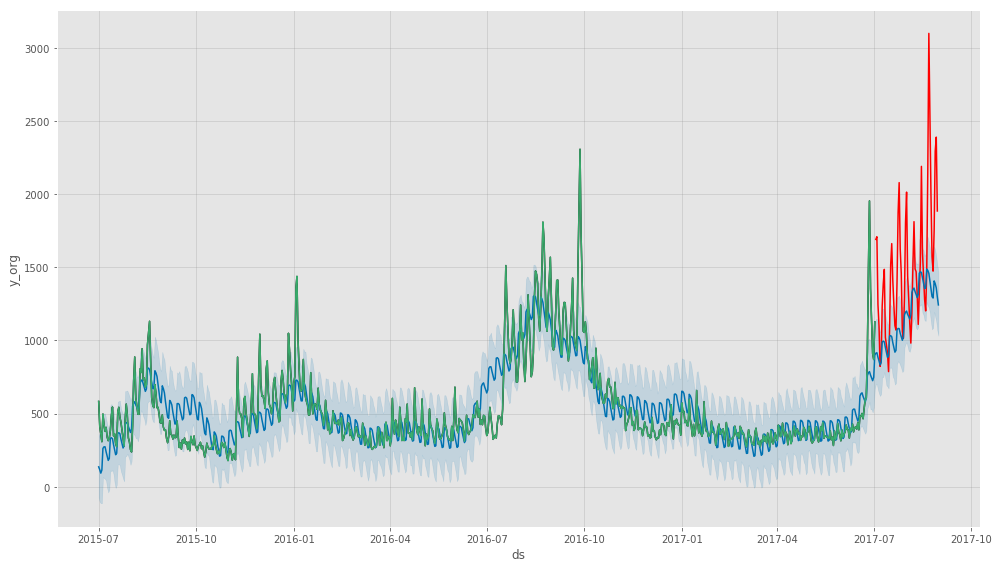

page_index                                                           57663
v7ty_val                                                           56.2012
v7t_val                                                            16.8403
Page                        青春18きっぷ_ja.wikipedia.org_mobile-web_all-agents
median_pred_60                                                         535
median_pred_120                                                        750
prevYear_median_pred_60                                                441
prevYear_median_pred_120                                               725
smape_60_to_0                                                      102.156
smape_120_to_60                                                    39.2037
prevYear_smape_60_to_0                                             70.2151
prevYear_smape_120_to_60                                           48.9187
nans_start_to_120                                                        0
nans_120_to_60           

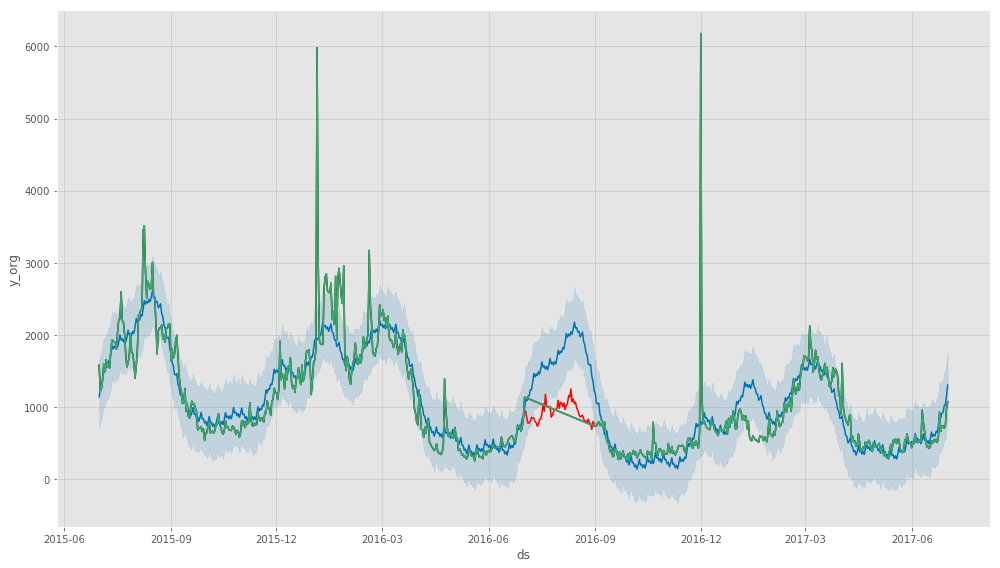

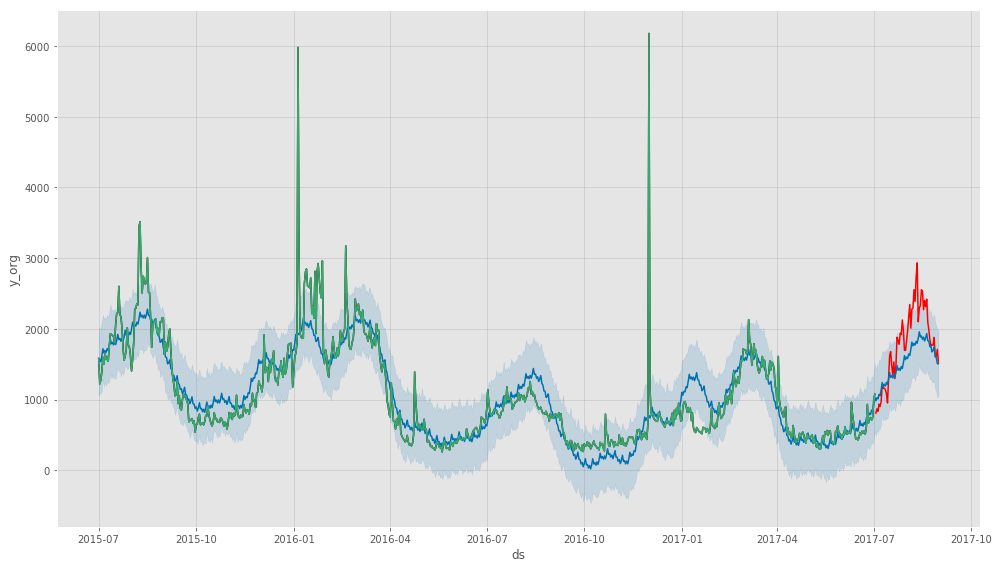

page_index                                                              38487
v7ty_val                                                              67.3972
v7t_val                                                               51.3562
Page                        List_of_Power_episodes_en.wikipedia.org_all-ac...
median_pred_60                                                           2269
median_pred_120                                                          1093
prevYear_median_pred_60                                                  1111
prevYear_median_pred_120                                                  736
smape_60_to_0                                                         135.529
smape_120_to_60                                                       61.1391
prevYear_smape_60_to_0                                                115.518
prevYear_smape_120_to_60                                              30.9871
nans_start_to_120                                               

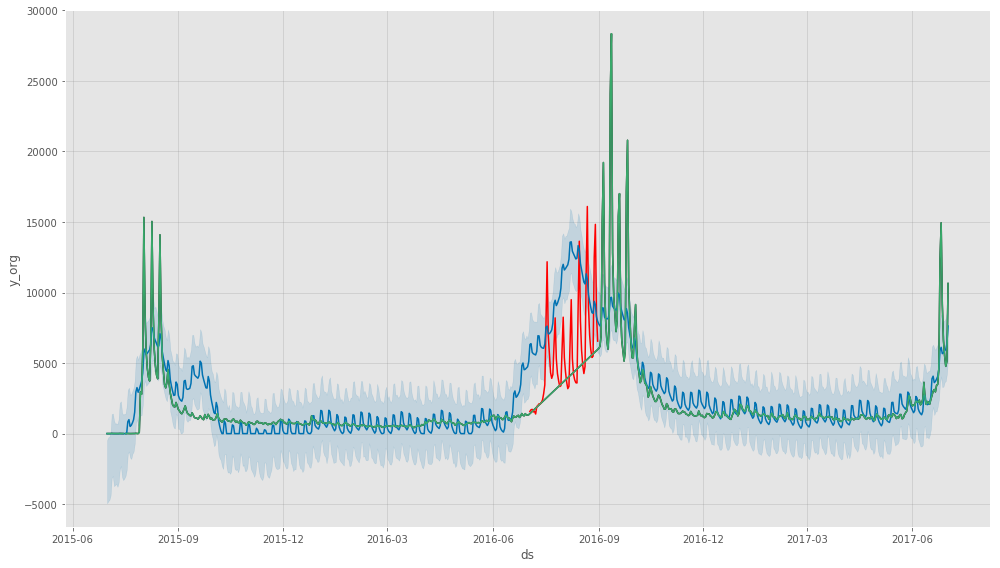

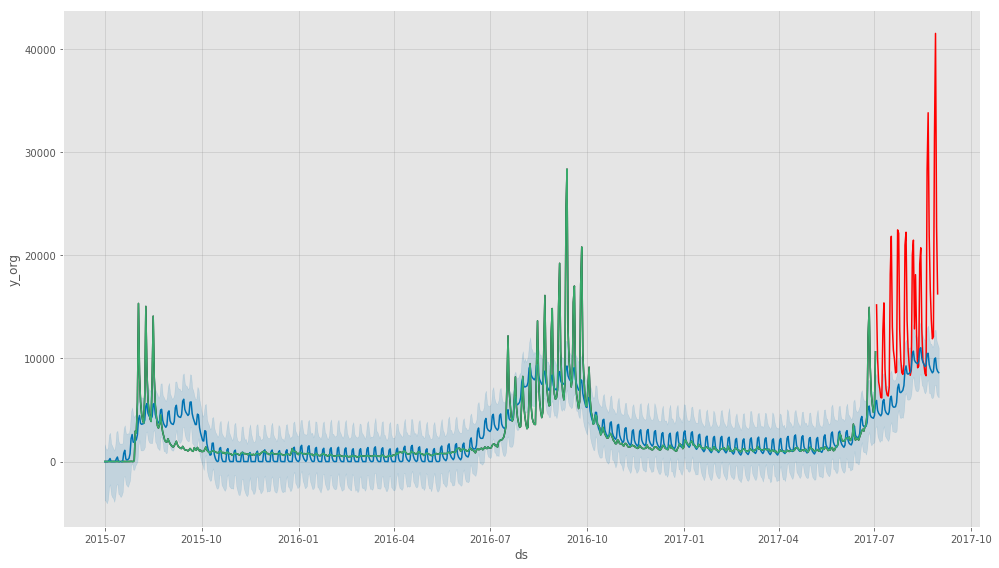

page_index                                                              55017
v7ty_val                                                              41.9666
v7t_val                                                               33.5972
Page                        Power_(série_télévisée)_fr.wikipedia.org_mobil...
median_pred_60                                                            228
median_pred_120                                                           199
prevYear_median_pred_60                                                   213
prevYear_median_pred_120                                                  201
smape_60_to_0                                                         116.941
smape_120_to_60                                                       28.7674
prevYear_smape_60_to_0                                                76.1523
prevYear_smape_120_to_60                                              15.9983
nans_start_to_120                                               

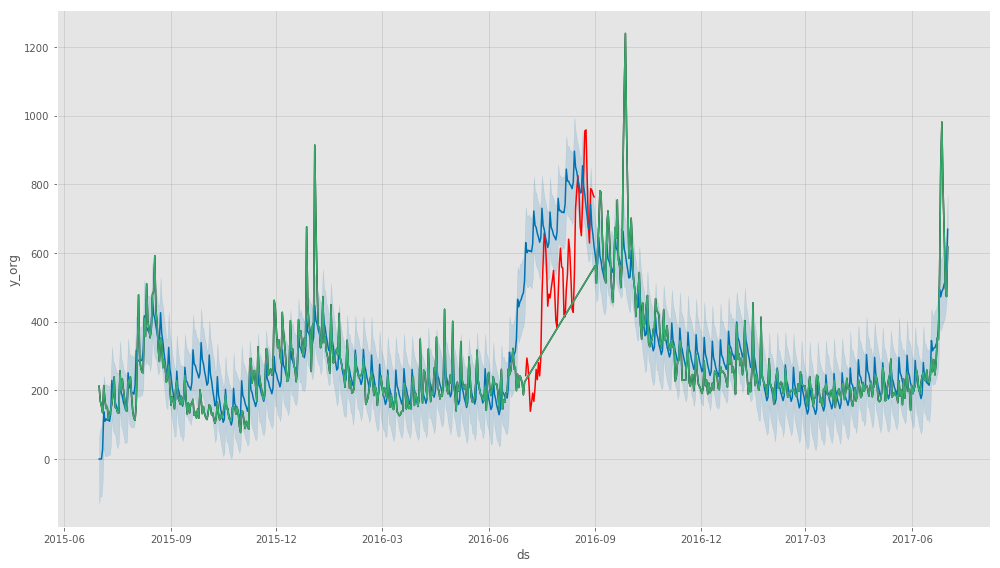

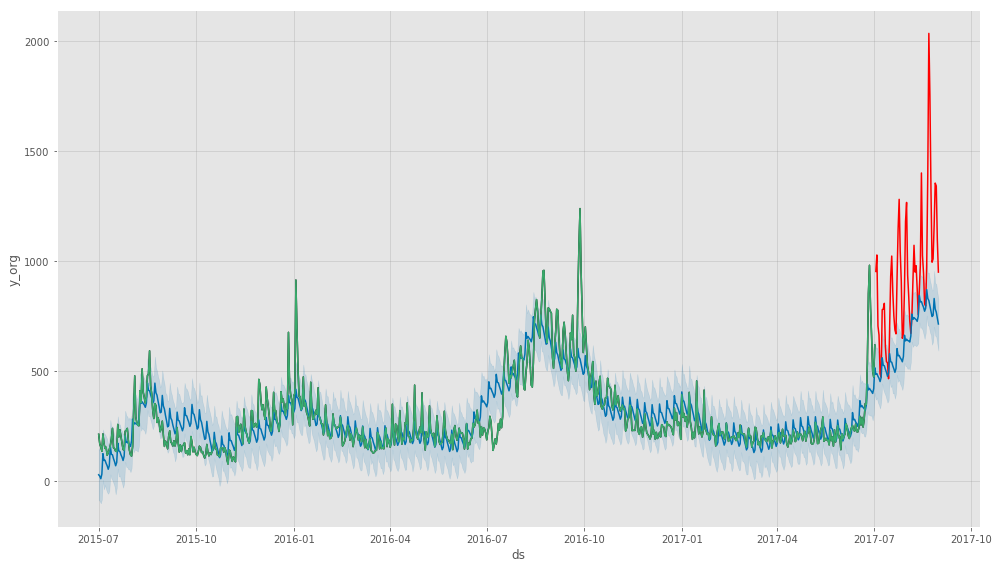

page_index                                                              11530
v7ty_val                                                              79.1016
v7t_val                                                               41.8169
Page                        List_of_NBA_champions_en.wikipedia.org_desktop...
median_pred_60                                                           7274
median_pred_120                                                          2850
prevYear_median_pred_60                                                  6796
prevYear_median_pred_120                                                 2946
smape_60_to_0                                                         124.448
smape_120_to_60                                                       84.9213
prevYear_smape_60_to_0                                                118.274
prevYear_smape_120_to_60                                              70.9497
nans_start_to_120                                               

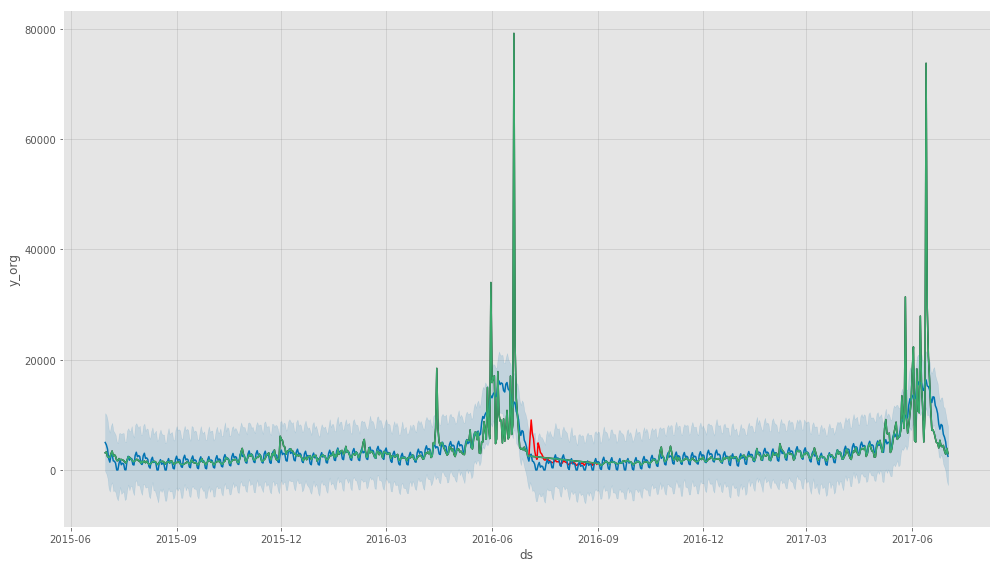

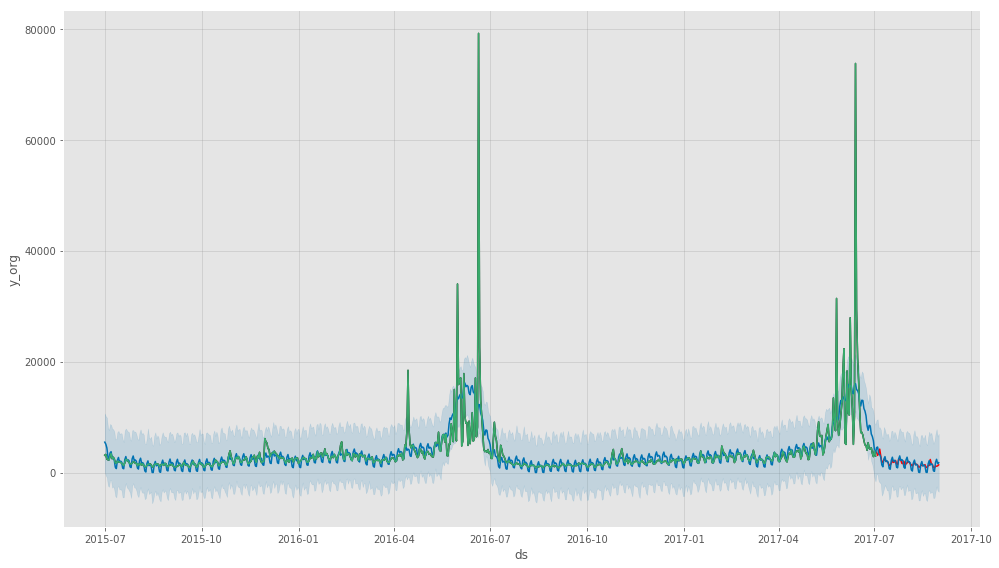

In [108]:
for row in df[(df['val_gain'] > 10) &
              (df['val_gain'] < 50) &
              (df['nans_start_to_120'] < 100) &
              (df['test_gain'] > 10) &
              (df['test_gain'] < 100)].sort_values(
    by='test_gain', ascending=False).iloc[:10].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

In [123]:
for row in df[(df['val_gain'] > 10) &
              (df['val_gain'] < 50) &
              (df['nans_start_to_120'] < 100) &
              (df['test_gain'] > -201) &
              (df['test_gain'] < 0)].sort_values(
    by='test_gain', ascending=False).iloc[:0].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

In [124]:
for row in df[(df['val_gain'] > 10) &
              (df['val_gain'] < 50) &
              (df['nans_start_to_120'] < 100) &
              (df['test_gain'] > -201) &
              (df['test_gain'] < 0)].sort_values(
    by='test_gain', ascending=True).iloc[:0].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

# Try Eliminating series predicting all 0 (negatives)

In [111]:
yhat = load_prophet_prop('v7t/', 'yhat')

In [122]:
zero_yhat_pages = yhat[yhat.iloc[:,-60:None].sum(axis=1) == 0].reset_index()['index']

In [127]:
def test_smape_for_thresholds_nozero(threshs):
    upper_threshold = threshs[0]
    lower_threshold  = threshs[1]
    nan_threhshold = threshs[2]
    filter_df = ((df.val_gain <= upper_threshold)
                 & (df.val_gain >= lower_threshold)
                 & (df.nans_start_to_120 <= nan_threhshold)
                 & (~df.page_index.isin(zero_yhat_pages))
                )
    proph_test_sum = df[filter_df].v7t_val.sum()
    proph_test_count = df[filter_df].v7t_val.count()
    smape_60_0_sum = df[~filter_df].smape_60_to_0.sum()
    smape_60_0_count = df[~filter_df].smape_60_to_0.count()
    return ((proph_test_sum + smape_60_0_sum) / (proph_test_count + smape_60_0_count))

In [128]:
test_smape_for_thresholds((201,0,700)) 

53.070024843399807

In [129]:
c = brute(test_smape_for_thresholds_nozero,[(0,200),(-200,200),(0,790)],full_output = True)

In [130]:
BASE_SMAPE

41.043204039840212

In [131]:
c

(array([ 200.        ,  189.47368421,  665.26315789]),
 41.042905531501752,
 array([[[[   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ],
          [   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ],
          [   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ],
          ..., 
          [   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ],
          [   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ],
          [   0.        ,    0.        ,    0.        , ...,    0.        ,
              0.        ,    0.        ]],
 
         [[  10.52631579,   10.52631579,   10.52631579, ...,   10.52631579,
             10.52631579,   10.52631579],
          [  10.52631579,   10.52631579,   10.52631579, ...,   10.52631579,
   

In [132]:
c[0]

array([ 200.        ,  189.47368421,  665.26315789])

In [133]:
BASE_SMAPE - c[1]

0.00029850833846012392

In [134]:
print(get_df_for_thresh(c[0]).shape)
get_df_for_thresh(c[0])

(3, 19)


,page_index,v7ty_val,v7t_val,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,smape_60_to_0,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60,val_gain,test_gain
6944,6944,3.669725,28.630112,Saison_5_d'Arrow_fr.wikipedia.org_desktop_all-...,475,708,0,0,41.444424,38.763043,200.0,NaN,427,0,0,59,60,196.330275,12.814313
23172,23172,7.692308,0.000000,Special:WhatLinksHere/Category:Hidden_categori...,0,0,1,1,0.000000,0.000000,200.0,86.650925,347,28,34,34,5,192.307692,0.000000
90059,90059,8.364208,NaN,特別:フィード項目/featured/20160830000000/ja_ja.wikipe...,0,0,0,0,NaN,NaN,200.0,NaN,635,60,60,58,60,191.635792,NaN
